# UK Gas Demand Forecasting (NTS)

This notebook develops a weather-aware forecasting pipeline for UK gas demand
on the National Transmission System (NTS).

The workflow proceeds in two stages:
1. Validation of forecasting logic using synthetic data
2. Application of the same pipeline to real UK gas demand and weather data


In [1]:
import pandas as pd 
import numpy as np

## 1. Synthetic Data Exploration (Pipeline Validation)
Synthetic data is used initially to validate feature engineering,
time-series splits, and modeling logic before introducing real-world
data complexity.


In [3]:
# create date range
dates = pd.date_range(start="2021-01-01", end="2022-12-31", freq="D")

# simulate UK-style temperature (cold winters, mild summers)
temp = 10 + 8 * np.sin(2 * np.pi * dates.dayofyear / 365) + np.random.normal(0, 1.5, len(dates))

# simulate UK gas demand (higher when temperature is lower)
demand = 3000 - 120 * temp + np.random.normal(0, 150, len(dates))

df = pd.DataFrame({
    "date": dates,
    "demand_gwh": demand,
    "mean_temp_c": temp
})

df.head()


,date,demand_gwh,mean_temp_c
0,2021-01-01,1872.862439,10.681829
1,2021-01-02,1657.315570,10.072757
2,2021-01-03,1419.149318,12.358519
3,2021-01-04,2172.390957,9.672373
4,2021-01-05,2011.196778,9.045666


In [4]:
# Heating Degree Days (UK standard baseline ~15.5°C)
df["hdd"] = (15.5 - df["mean_temp_c"]).clip(lower=0)

df.head()


,date,demand_gwh,mean_temp_c,hdd
0,2021-01-01,1872.862439,10.681829,4.818171
1,2021-01-02,1657.315570,10.072757,5.427243
2,2021-01-03,1419.149318,12.358519,3.141481
3,2021-01-04,2172.390957,9.672373,5.827627
4,2021-01-05,2011.196778,9.045666,6.454334


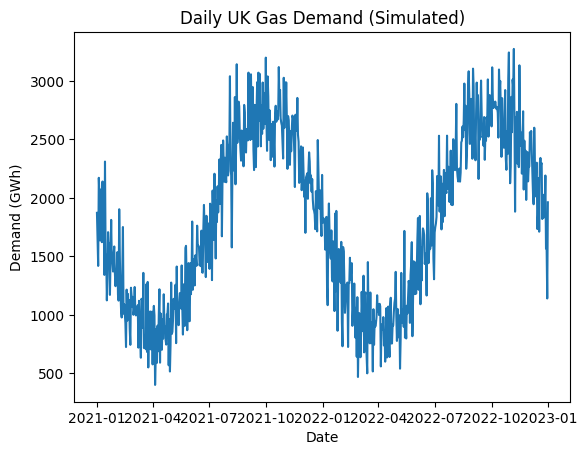

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["date"], df["demand_gwh"])
plt.title("Daily UK Gas Demand (Simulated)")
plt.xlabel("Date")
plt.ylabel("Demand (GWh)")
plt.show()


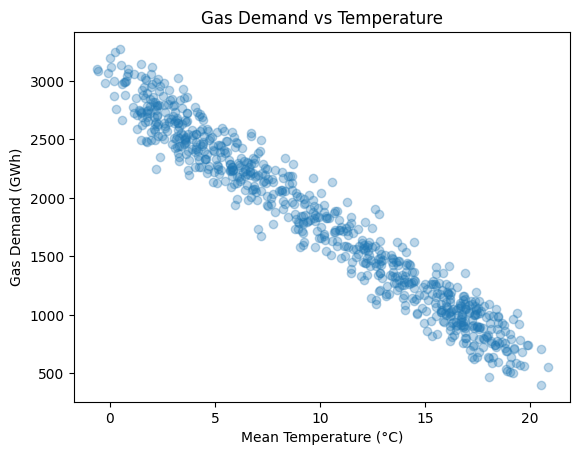

In [6]:
plt.figure()
plt.scatter(df["mean_temp_c"], df["demand_gwh"], alpha=0.3)
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Gas Demand (GWh)")
plt.title("Gas Demand vs Temperature")
plt.show()


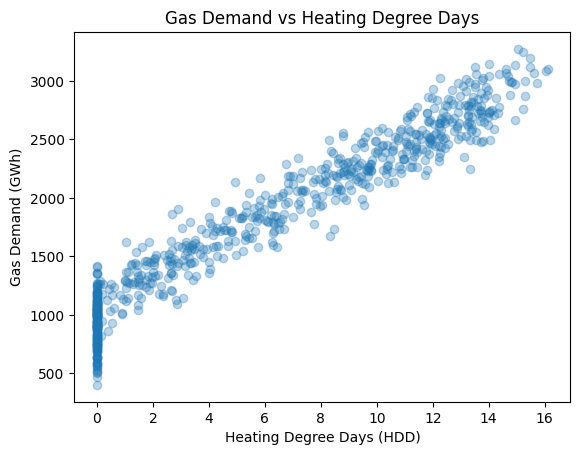

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df["hdd"], df["demand_gwh"], alpha=0.3)
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("Gas Demand (GWh)")
plt.title("Gas Demand vs Heating Degree Days")
plt.show()


In [8]:
df[["demand_gwh", "mean_temp_c", "hdd"]].corr()


,demand_gwh,mean_temp_c,hdd
demand_gwh,1.000000,-0.976104,0.967620
mean_temp_c,-0.976104,1.000000,-0.989459
hdd,0.967620,-0.989459,1.000000


In [9]:
df["demand_lag_1"] = df["demand_gwh"].shift(1)
df["demand_lag_7"] = df["demand_gwh"].shift(7)

df.head(10)


,date,demand_gwh,mean_temp_c,hdd,demand_lag_1,demand_lag_7
0,2021-01-01,1872.862439,10.681829,4.818171,NaN,NaN
1,2021-01-02,1657.315570,10.072757,5.427243,1872.862439,NaN
2,2021-01-03,1419.149318,12.358519,3.141481,1657.315570,NaN
3,2021-01-04,2172.390957,9.672373,5.827627,1419.149318,NaN
4,2021-01-05,2011.196778,9.045666,6.454334,2172.390957,NaN
5,2021-01-06,1636.942736,12.008555,3.491445,2011.196778,NaN
6,2021-01-07,2072.374771,8.687885,6.812115,1636.942736,NaN
7,2021-01-08,1695.765127,10.199802,5.300198,2072.374771,1872.862439
8,2021-01-09,1622.028453,9.262313,6.237687,1695.765127,1657.315570
9,2021-01-10,2140.766705,10.578995,4.921005,1622.028453,1419.149318


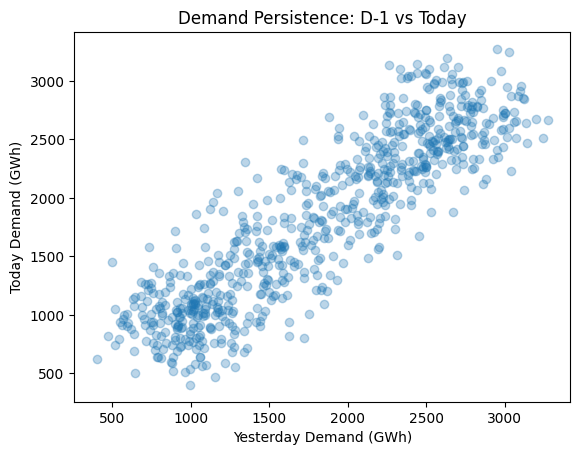

In [10]:
plt.figure()
plt.scatter(df["demand_lag_1"], df["demand_gwh"], alpha=0.3)
plt.xlabel("Yesterday Demand (GWh)")
plt.ylabel("Today Demand (GWh)")
plt.title("Demand Persistence: D-1 vs Today")
plt.show()


In [11]:
df["demand_roll_7"] = df["demand_gwh"].rolling(7).mean()
df["demand_roll_14"] = df["demand_gwh"].rolling(14).mean()

df.head(15)


,date,demand_gwh,mean_temp_c,hdd,demand_lag_1,demand_lag_7,demand_roll_7,demand_roll_14
0,2021-01-01,1872.862439,10.681829,4.818171,NaN,NaN,NaN,NaN
1,2021-01-02,1657.315570,10.072757,5.427243,1872.862439,NaN,NaN,NaN
2,2021-01-03,1419.149318,12.358519,3.141481,1657.315570,NaN,NaN,NaN
3,2021-01-04,2172.390957,9.672373,5.827627,1419.149318,NaN,NaN,NaN
4,2021-01-05,2011.196778,9.045666,6.454334,2172.390957,NaN,NaN,NaN
5,2021-01-06,1636.942736,12.008555,3.491445,2011.196778,NaN,NaN,NaN
6,2021-01-07,2072.374771,8.687885,6.812115,1636.942736,NaN,1834.604653,NaN
7,2021-01-08,1695.765127,10.199802,5.300198,2072.374771,1872.862439,1809.305036,NaN
8,2021-01-09,1622.028453,9.262313,6.237687,1695.765127,1657.315570,1804.264020,NaN
9,2021-01-10,2140.766705,10.578995,4.921005,1622.028453,1419.149318,1907.352218,NaN


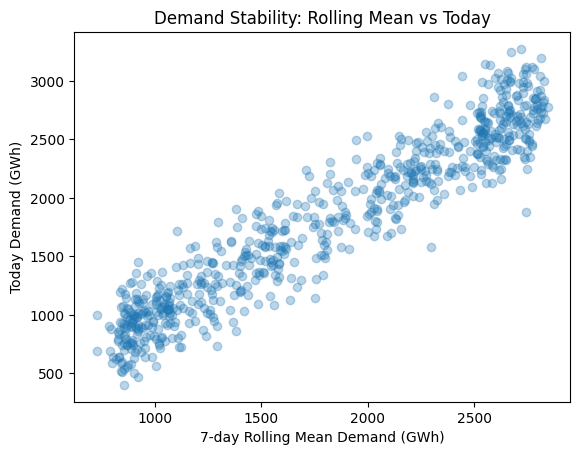

In [12]:
plt.figure()
plt.scatter(df["demand_roll_7"], df["demand_gwh"], alpha=0.3)
plt.xlabel("7-day Rolling Mean Demand (GWh)")
plt.ylabel("Today Demand (GWh)")
plt.title("Demand Stability: Rolling Mean vs Today")
plt.show()


In [13]:
df[
    ["demand_gwh", "demand_lag_1", "demand_lag_7", "demand_roll_7", "demand_roll_14"]
].corr()


,demand_gwh,demand_lag_1,demand_lag_7,demand_roll_7,demand_roll_14
demand_gwh,1.000000,0.888493,0.885574,0.949569,0.940972
demand_lag_1,0.888493,1.000000,0.883039,0.950638,0.942411
demand_lag_7,0.885574,0.883039,1.000000,0.932863,0.947641
demand_roll_7,0.949569,0.950638,0.932863,1.000000,0.993945
demand_roll_14,0.940972,0.942411,0.947641,0.993945,1.000000


In [14]:
df_model = df.dropna().copy()


In [15]:
train_size = int(len(df_model) * 0.8)

train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]


In [16]:
test["baseline_pred"] = test["demand_lag_1"]


C:\Users\Aditya\AppData\Local\Temp\ipykernel_22548\4282314506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["baseline_pred"] = test["demand_lag_1"]


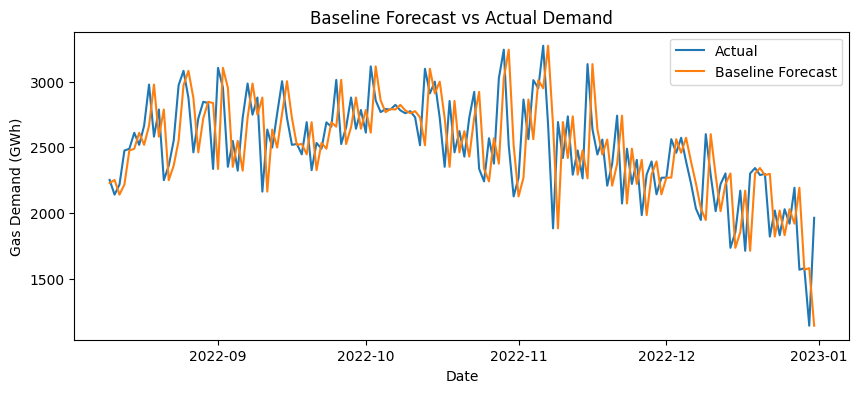

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(test["date"], test["demand_gwh"], label="Actual")
plt.plot(test["date"], test["baseline_pred"], label="Baseline Forecast")
plt.legend()
plt.title("Baseline Forecast vs Actual Demand")
plt.xlabel("Date")
plt.ylabel("Gas Demand (GWh)")
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error

mae_baseline = mean_absolute_error(
    test["demand_gwh"],
    test["baseline_pred"]
)

mae_baseline


274.7454816291066

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [20]:
features = [
    "hdd",
    "demand_lag_1",
    "demand_lag_7",
    "demand_roll_7"
]

X_train = train[features]
y_train = train["demand_gwh"]

X_test = test[features]
y_test = test["demand_gwh"]


In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [22]:
test["lr_pred"] = lr.predict(X_test)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_22548\1182857081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["lr_pred"] = lr.predict(X_test)


In [23]:
mae_lr = mean_absolute_error(y_test, test["lr_pred"])
mae_lr


145.1747074503454

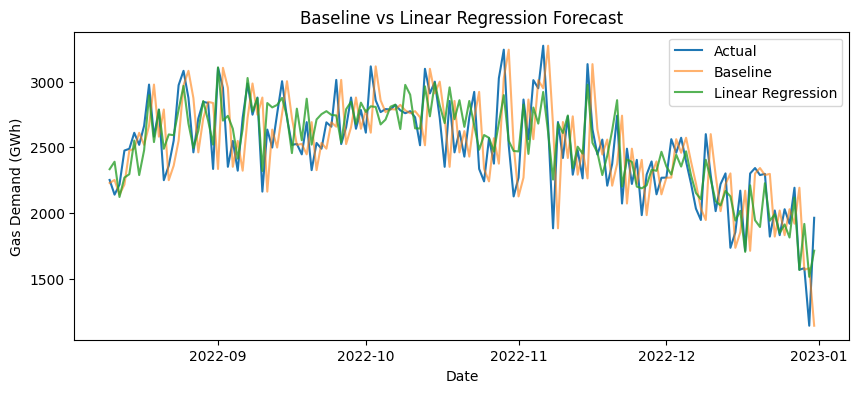

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(test["date"], y_test, label="Actual")
plt.plot(test["date"], test["baseline_pred"], label="Baseline", alpha=0.6)
plt.plot(test["date"], test["lr_pred"], label="Linear Regression", alpha=0.8)
plt.legend()
plt.title("Baseline vs Linear Regression Forecast")
plt.xlabel("Date")
plt.ylabel("Gas Demand (GWh)")
plt.show()


In [25]:
pd.Series(lr.coef_, index=features)


hdd              99.054863
demand_lag_1     -0.156374
demand_lag_7     -0.041638
demand_roll_7     0.470734
dtype: float64

## 2. Real UK Gas Demand Data (NTS Actual D+6)
NTS Actual D+6 demand is used to ensure finalized, settlement-grade
gas demand values. For each gas day, the latest published value
is retained.


In [2]:
import pandas as pd

demand_raw = pd.read_csv(
    "../data/raw/uk_gas_demand_daily.csv"
)

demand_raw.head()

,Applicable At,Applicable For,Data Item,Value,Generated Time,Quality Indicator
0,15/01/2026 10:20:01,09/01/2026,"Demand Actual, NTS, D+6",321.824,15/01/2026 12:00:00,NaN
1,14/01/2026 10:20:00,08/01/2026,"Demand Actual, NTS, D+6",357.490,14/01/2026 12:00:00,NaN
2,13/01/2026 10:20:01,07/01/2026,"Demand Actual, NTS, D+6",339.761,13/01/2026 12:00:00,NaN
3,12/01/2026 10:20:00,06/01/2026,"Demand Actual, NTS, D+6",378.123,12/01/2026 12:00:00,NaN
4,11/01/2026 10:20:01,05/01/2026,"Demand Actual, NTS, D+6",407.523,11/01/2026 12:00:00,NaN


In [3]:
demand_raw["Applicable For"] = pd.to_datetime(demand_raw["Applicable For"], dayfirst=True)
demand_raw["Generated Time"] = pd.to_datetime(demand_raw["Generated Time"])

demand_raw.dtypes


C:\Users\Aditya\AppData\Local\Temp\ipykernel_26712\3397231416.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  demand_raw["Generated Time"] = pd.to_datetime(demand_raw["Generated Time"])


Applicable At                object
Applicable For       datetime64[ns]
Data Item                    object
Value                       float64
Generated Time       datetime64[ns]
Quality Indicator            object
dtype: object

In [28]:
demand_raw["Applicable For"].value_counts().head()


Applicable For
2021-02-22    5
2021-02-21    4
2021-03-28    4
2022-04-05    4
2022-04-06    4
Name: count, dtype: int64

In [29]:
demand_raw["Value"].describe()


count    2976.000000
mean      230.493232
std       121.882949
min         0.000000
25%       180.034500
50%       224.203162
75%       270.814851
max      5810.298990
Name: Value, dtype: float64

In [30]:
# sort so latest publication comes last
demand_sorted = demand_raw.sort_values(
    ["Applicable For", "Generated Time"]
)

# keep the latest record per Gas Day
demand_daily = demand_sorted.drop_duplicates(
    subset=["Applicable For"],
    keep="last"
).copy()

demand_daily.head()


,Applicable At,Applicable For,Data Item,Value,Generated Time,Quality Indicator
2973,17/01/2021 12:30:59,2021-01-11,"Demand Actual, NTS, D+6",327.862363,2021-04-28 16:08:01,L
2970,18/01/2021 12:30:59,2021-01-12,"Demand Actual, NTS, D+6",350.111724,2021-04-28 16:08:01,L
2967,19/01/2021 12:30:59,2021-01-13,"Demand Actual, NTS, D+6",355.076835,2021-04-28 16:08:01,L
2964,20/01/2021 12:30:59,2021-01-14,"Demand Actual, NTS, D+6",357.114328,2021-04-28 16:08:01,L
2961,21/01/2021 12:30:59,2021-01-15,"Demand Actual, NTS, D+6",362.616582,2021-04-28 16:08:01,L


In [31]:
# one row per gas day
demand_daily["Applicable For"].is_unique


True

In [32]:
# compare counts
len(demand_raw), len(demand_daily)


(2976, 1825)

In [33]:
demand_daily["Value"].describe()


count    1825.000000
mean      218.240701
std        64.623203
min        91.816700
25%       161.080000
50%       215.156000
75%       264.043949
max       416.427180
Name: Value, dtype: float64

In [34]:
demand_daily = demand_daily.rename(columns={
    "Applicable For": "date",
    "Value": "demand_mscm"
})

demand_daily = demand_daily[["date", "demand_mscm"]].sort_values("date")

demand_daily.head()


,date,demand_mscm
2973,2021-01-11,327.862363
2970,2021-01-12,350.111724
2967,2021-01-13,355.076835
2964,2021-01-14,357.114328
2961,2021-01-15,362.616582


In [35]:
MSCM_TO_GWH = 11.1

demand_daily["demand_gwh"] = demand_daily["demand_mscm"] * MSCM_TO_GWH

demand_daily[["date", "demand_gwh"]].head()


,date,demand_gwh
2973,2021-01-11,3639.272224
2970,2021-01-12,3886.240132
2967,2021-01-13,3941.352863
2964,2021-01-14,3963.969042
2961,2021-01-15,4025.044056


In [36]:
demand_daily["demand_gwh"].describe()


count    1825.000000
mean     2422.471781
std       717.317557
min      1019.165370
25%      1787.988000
50%      2388.231600
75%      2930.887836
max      4622.341698
Name: demand_gwh, dtype: float64

## 3. Real UK Weather Data (Central England Temperature)
Central England Temperature (CET) is used as a national-level proxy
for UK temperature and is commonly applied in energy demand studies.


In [58]:
weather_raw = pd.read_csv(
    "../data/raw/uk_temperature_daily.csv",
    sep=r"\s+",
    engine="python"
)

weather_raw.head()


,Date,Value
0,1772-01-01,3.2
1,1772-01-02,2.0
2,1772-01-03,2.7
3,1772-01-04,2.7
4,1772-01-05,1.5


In [51]:
weather_raw.columns
weather_raw.shape



(92788, 2)

In [59]:
weather_daily = weather_raw.rename(
    columns={"Date": "date", "Value": "mean_temp"}
)
weather_raw["date"] = pd.to_datetime(weather_raw["Date"])

## 4. Heating Degree Days (HDD)
Heating Degree Days are computed using a base temperature of 15.5°C,
a standard threshold for UK space heating demand.


In [60]:
BASE_TEMP = 15.5

weather_daily["hdd"] = (BASE_TEMP - weather_daily["mean_temp"]).clip(lower=0)

weather_daily[["mean_temp", "hdd"]].describe()


,mean_temp,hdd
count,92788.000000,92788.000000
mean,9.421188,6.340367
std,5.346914,4.952558
min,-11.900000,0.000000
25%,5.400000,1.700000
50%,9.400000,6.100000
75%,13.800000,10.100000
max,28.100000,27.400000


In [63]:
demand_daily["date"] = pd.to_datetime(demand_daily["date"])
weather_daily["date"] = pd.to_datetime(weather_daily["date"])


## 5. Demand–Weather Alignment
Only dates with both demand and weather observations are retained
to avoid data leakage.


In [64]:
df_real = demand_daily.merge(
    weather_daily[["date", "mean_temp", "hdd"]],
    on="date",
    how="inner"
)

df_real.head()



,date,demand_mscm,demand_gwh,mean_temp,hdd
0,2021-01-11,327.862363,3639.272224,4.8,10.7
1,2021-01-12,350.111724,3886.240132,5.1,10.4
2,2021-01-13,355.076835,3941.352863,3.8,11.7
3,2021-01-14,357.114328,3963.969042,4.3,11.2
4,2021-01-15,362.616582,4025.044056,2.0,13.5


In [67]:
df_real.shape


(1825, 5)

## 6. Feature Engineering
Lag and rolling features capture demand persistence and weekly
system behavior.


In [68]:
df = df_real.copy()

df["demand_lag_1"] = df["demand_gwh"].shift(1)
df["demand_lag_7"] = df["demand_gwh"].shift(7)
df["demand_roll_7"] = df["demand_gwh"].rolling(7).mean()

df_model = df.dropna().copy()


## 7. Baseline Forecast
A persistence baseline using previous-day demand provides a strong
benchmark for short-term forecasting.


In [69]:
from sklearn.metrics import mean_absolute_error

baseline_pred = df_model["demand_lag_1"]
mae_baseline_real = mean_absolute_error(
    df_model["demand_gwh"],
    baseline_pred
)

mae_baseline_real


140.47083229296578

## 8. Weather-Aware Linear Regression Model
A linear regression model is used to assess whether weather information
provides incremental value over demand history alone.


In [70]:
from sklearn.linear_model import LinearRegression

features = ["hdd", "demand_lag_1", "demand_lag_7", "demand_roll_7"]
X = df_model[features]
y = df_model["demand_gwh"]

lr = LinearRegression()
lr.fit(X, y)

lr_pred = lr.predict(X)
mae_lr_real = mean_absolute_error(y, lr_pred)

mae_lr_real


129.74132056361356

In [71]:
pd.Series(lr.coef_, index=features).sort_values()


demand_lag_7      0.010318
demand_roll_7     0.233519
demand_lag_1      0.601713
hdd              26.284531
dtype: float64

## 9. Results and Interpretation
Incorporating weather information via Heating Degree Days produces a
material reduction in forecast error compared to a strong naïve baseline.

The results confirm that UK gas demand is strongly weather-driven,
and that simple, interpretable models can deliver meaningful
forecasting improvements.

